<a href="https://colab.research.google.com/github/ArpanSM/Machine_Learning_Hackathons/blob/master/TheMathCompany_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings                                 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
trainx = pd.read_csv("/content/drive/MyDrive/Projects/TheMathCompany_.DSHH/fe_train.csv")
testx = pd.read_csv("/content/drive/MyDrive/Projects/TheMathCompany_.DSHH/fe_test.csv")
subx = pd.read_csv("/content/drive/MyDrive/Projects/TheMathCompany_.DSHH/submission.csv")
pd.set_option('display.max_columns', 500)
trainx.shape, testx.shape

((19229, 189), (8245, 188))

#Scikit-Optimize

In [ ]:
!pip install scikit-optimize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split, KFold, cross_validate

from skopt import gp_minimize, forest_minimize, gbrt_minimize
from skopt.plots import plot_convergence,plot_evaluations,plot_objective,plot_gaussian_process
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

     |████████████████████████████████| 102kB 11.1MB/s 


In [ ]:
X = trainx.drop(labels= ['ID', 'Price'], axis = 1)
y = trainx['Price']

# split dataset into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, X_test.shape

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

dft = testx.drop(labels= ['ID'], axis = 1)
dft.reset_index(drop=True, inplace=True)

X_train.shape, y_train.shape, dft.shape

((13460, 187), (13460,), (8245, 187))

In [ ]:
trainx.columns[trainx.isna().any()].tolist()

[]

In [ ]:
testx.columns[testx.isna().any()].tolist()

[]

####XGBoost GPU

In [ ]:
# defining the space
param_grid_reg = [
    Integer(100, 1000, name="n_estimators"),
    Real(0.05, 0.3, name="learning_rate", prior="log-uniform"),
    Integer(3, 10, name="max_depth"),
    Real(1, 12, name="min_child_weight"),
    Real(0.5, 0.9, name="colsample_bytree"),
    Real(0.5, 0.9, name="subsample"),
    Real(0.001, 100, name="reg_alpha", prior="log-uniform"),
]

from xgboost import XGBRegressor
xgb = XGBRegressor(random_state=0, xgb_gpu_hist = 1)

@use_named_args(param_grid_reg)
def objective(**params):
    
    # model with new parameters
    xgb.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            xgb, 
            X_train,
            y_train,
            cv=3,
            n_jobs=-1,
            scoring='neg_root_mean_squared_error'
        )
    )

    # negate because if you need to minimize
    return -value

# gbrt_minimize performs by Bayesian Optimization using GBMs as surrogate for f(x)

gbm_ = gbrt_minimize(
    objective, # the objective function to minimize
    param_grid_reg, # the hyperparameter space
    n_initial_points=60, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=100, # the number of subsequent evaluations of f(x)
    random_state=0, 
    verbose=True,
    n_jobs=-1,
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 67.8772
Function value obtained: 10676.8751
Current minimum: 10676.8751
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 60.6581
Function value obtained: 10622.3888
Current minimum: 10622.3888
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 58.7005
Function value obtained: 10555.7793
Current minimum: 10555.7793
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 126.5677
Function value obtained: 10744.8969
Current minimum: 10555.7793
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 61.2306
Function value obtained: 10721.9188
Current minimum: 

In [ ]:
# function value at the minimum.
"Best score=%.4f" % gbm_.fun

'Best score=9989.2983'

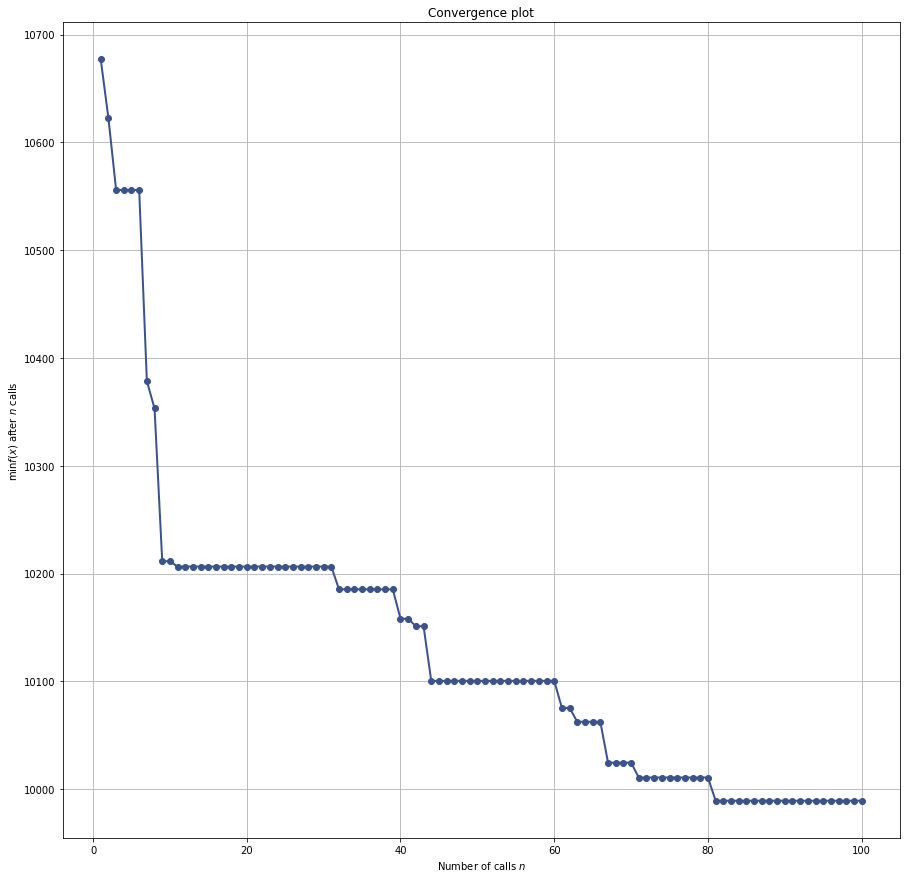

In [ ]:
plot_convergence(gbm_)

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(random_state=0, 
                  xgb_gpu_hist = 1,
                  n_estimators= gbm_.x[0],
                  learning_rate= gbm_.x[1],
                  max_depth = gbm_.x[2],
                  min_child_weight = gbm_.x[3],
                  colsample_bytree = gbm_.x[4],
                  subsample = gbm_.x[5],
                  reg_alpha =  gbm_.x[6],
                  )

xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6285516313782635, gamma=0,
             importance_type='gain', learning_rate=0.05878316665242285,
             max_delta_step=0, max_depth=10, min_child_weight=6.540977065739142,
             missing=None, n_estimators=147, n_jobs=1, nthread=None,
             objective='reg:linear', random_state=0,
             reg_alpha=2.0042764073285015, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.7126789003396041, verbosity=1,
             xgb_gpu_hist=1)

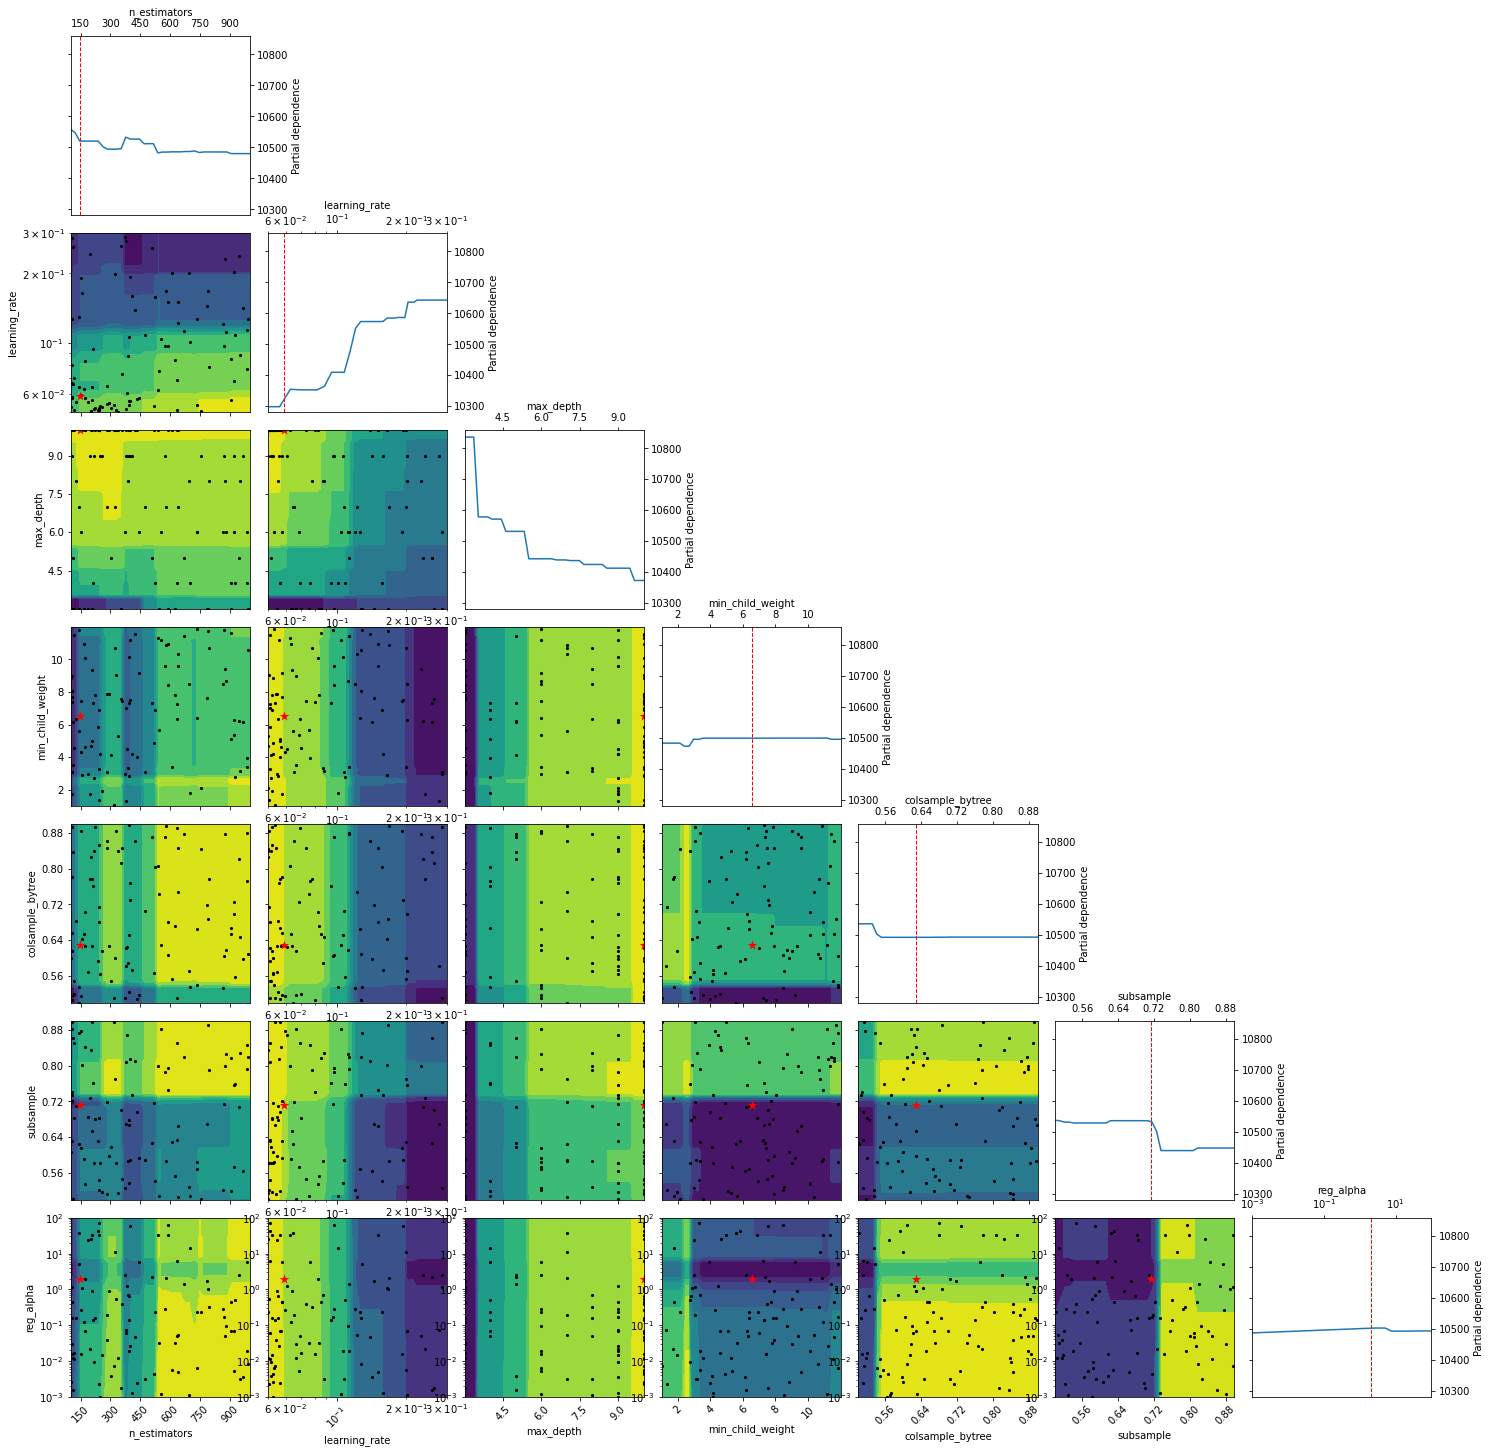

In [ ]:
dim_names = ['n_estimators','learning_rate','max_depth','min_child_weight','colsample_bytree', 'subsample' ,'reg_alpha']
plt.rcParams["figure.figsize"] = (15,15)
plot_objective(result=gbm_, plot_dims=dim_names,size=3)
plt.show()

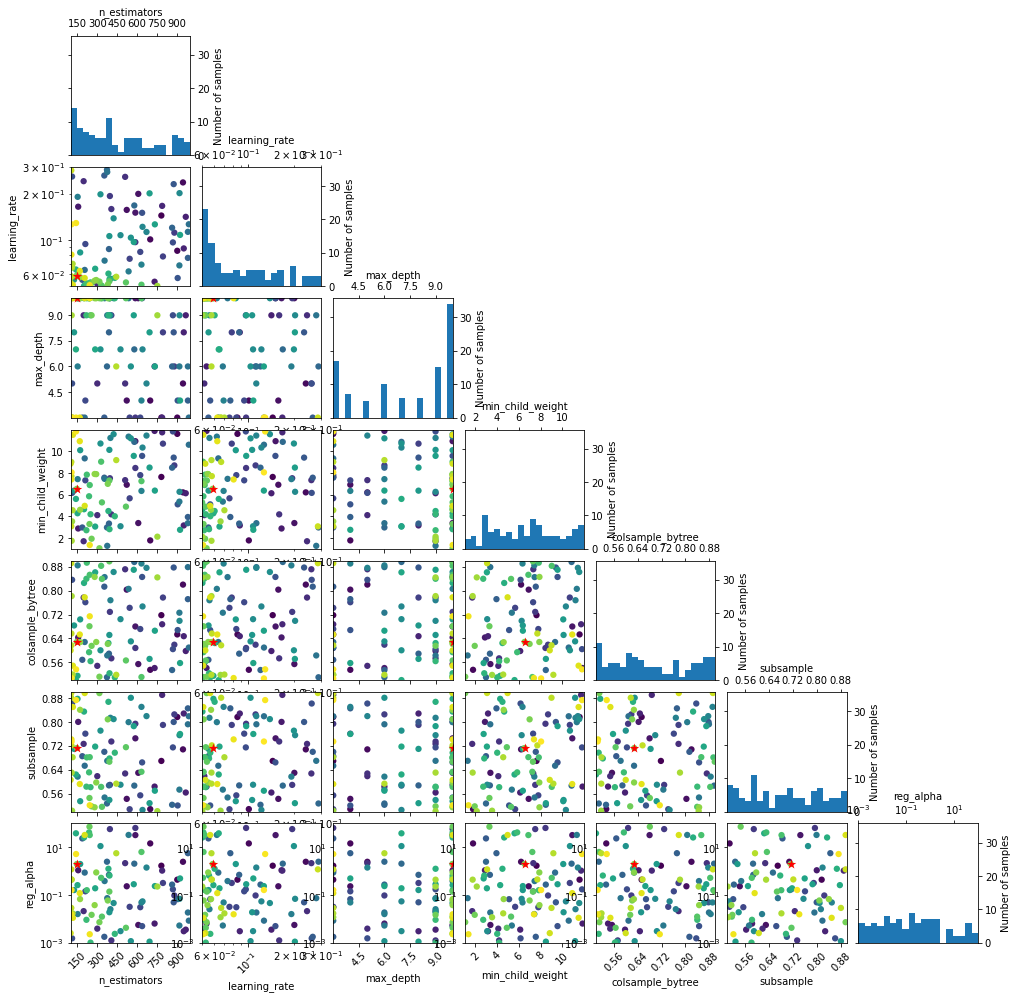

In [ ]:
plot_evaluations(result=gbm_, plot_dims=dim_names)
plt.show()

In [ ]:
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=4)

# estimate generalization error
clf =  cross_validate(
    xgb,
    X, 
    y,
    scoring='r2',
    return_train_score=True,
    cv=kf, # k-fold
)

clf['test_score'], clf['test_score'].mean()

[16:36:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(array([0.7690048 , 0.73091247, 0.70238767, 0.69878413, 0.66369031]),
 0.7129558748385806)

0.7024950192396608

In [ ]:
'''
# forest_minimize performs Bayesian Optimization 
# using Random Forests as surrogate

fm_ = forest_minimize(
    objective, # the objective function to minimize
    param_grid_reg, # the hyperparameter space
    base_estimator = 'RF', # the surrogate
    n_initial_points=15, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=20, # the number of subsequent evaluations of f(x)
    random_state=0, 
    verbose=True,
    n_jobs=-1,
)

# gp_minimize performs by default GP Optimization using a Marten Kernel
gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid_reg, # the hyperparameter space
    n_initial_points=15, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=20, # the number of subsequent evaluations of f(x)
    random_state=0,
    verbose=True,
    n_jobs=-1,
)

from xgboost import XGBRegressor
xgb = XGBRegressor(random_state=0, 
                  xgb_gpu_hist = 1,
                  n_estimators= gp_.x[0],
                  learning_rate= gp_.x[1],
                  max_depth = gp_.x[2],
                  min_child_weight = gp_.x[3],
                  colsample_bytree = gp_.x[4],
                  subsample = gp_.x[5],
                   reg_alpha =  gp_.x[6],
                  )

xgb
'''

####CatBoost GPU

In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2MB 39kB/s 


In [ ]:
# defining the space
param_grid_reg = [
    Integer(100, 600, name="n_estimators"),
    Real(0.05, 0.3, name="learning_rate", prior="log-uniform"),
    Integer(3, 15, name="depth"),
    Integer(3, 30, name="l2_leaf_reg"),
]

from catboost import CatBoostClassifier, CatBoostRegressor
cb = CatBoostRegressor(task_type='GPU', random_state=0, verbose=False, max_bin=254)

@use_named_args(param_grid_reg)
def objective(**params):
    
    # model with new parameters
    cb.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            cb, 
            X_train,
            y_train,
            cv=3,
            #n_jobs=-1,
            scoring='neg_root_mean_squared_error'
        )
    )

    # negate because if you need to minimize
    return -value

# gbrt_minimize performs by Bayesian Optimization 
# using GBMs as surrogate for f(x)

gbm_ = gbrt_minimize(
    objective, # the objective function to minimize
    param_grid_reg, # the hyperparameter space
    n_initial_points=60, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=100, # the number of subsequent evaluations of f(x)
    random_state=0, 
    verbose=True,
    n_jobs=-1,
)

# function value at the minimum.
"Best score=%.4f" % gbm_.fun

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.0820
Function value obtained: 11464.8788
Current minimum: 11464.8788
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 26.3920
Function value obtained: 10222.1213
Current minimum: 10222.1213
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 12.5146
Function value obtained: 10211.4969
Current minimum: 10211.4969
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 84.5550
Function value obtained: 13224.5300
Current minimum: 10211.4969
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 43.4458
Function value obtained: 13885.9222
Current minimum: 10

'Best score=10002.0853'

In [ ]:
gbm_.x

[447, 0.21817467080001723, 10, 30]

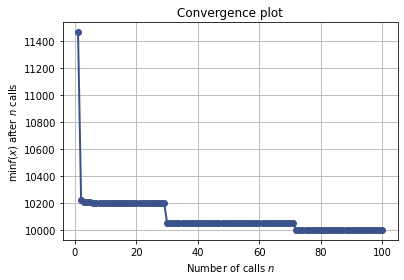

In [ ]:
plot_convergence(gbm_)

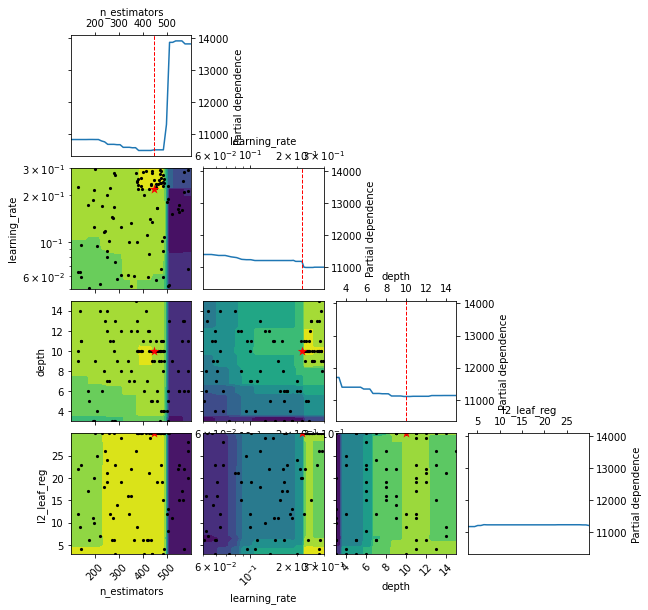

In [ ]:
dim_names = ['n_estimators', 'learning_rate','depth' , 'l2_leaf_reg']
plt.rcParams["figure.figsize"] = (15,15)
plot_objective(result=gbm_, plot_dims=dim_names,size=2)
plt.show()

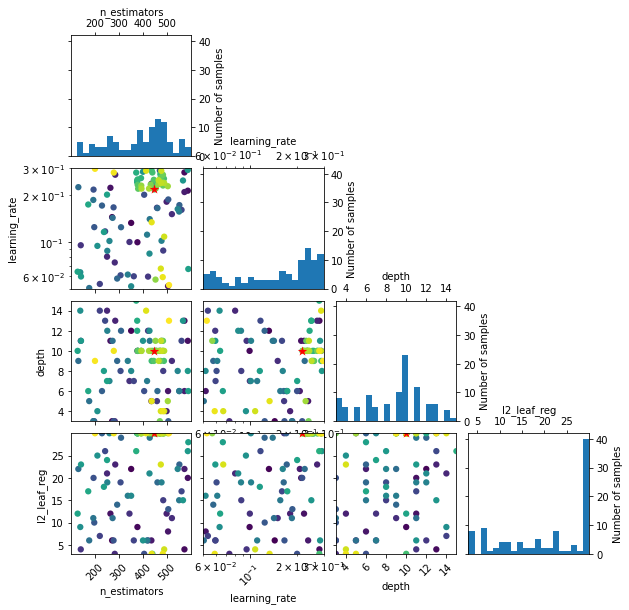

In [ ]:
plot_evaluations(result=gbm_, plot_dims=dim_names)
plt.show()

In [ ]:
cb = CatBoostRegressor(task_type='GPU', 
                       random_state=0, 
                       verbose=False,
                       max_bin = 254,
                       n_estimators = gbm_.x[0],
                       learning_rate = gbm_.x[1],
                       depth = gbm_.x[2],
                       l2_leaf_reg = gbm_.x[3])

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=4)

# estimate generalization error
clf =  cross_validate(
    cb,
    X, 
    y,
    scoring='r2',
    return_train_score=True,
    cv=kf,
)

clf['test_score'], clf['test_score'].mean()

(array([0.73456194, 0.70231735, 0.69004596, 0.66902429, 0.65566848]),
 0.6903236040818476)

In [ ]:
x = cb.get_params()
x

{'depth': 10,
 'l2_leaf_reg': 30,
 'learning_rate': 0.21817467080001723,
 'loss_function': 'RMSE',
 'max_bin': 254,
 'n_estimators': 447,
 'random_state': 0,
 'task_type': 'GPU',
 'verbose': False}

####Random Forest Regressor

In [ ]:
# defining the space
param_grid_reg = [
    Integer(100, 1000, name="n_estimators"),
    Integer(3, 15, name="max_depth")
]

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=0, n_jobs=-1,)

@use_named_args(param_grid_reg)
def objective(**params):
    
    # model with new parameters
    rf.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            rf, 
            X_train,
            y_train,
            cv=3,
            n_jobs=-1,
            scoring='neg_root_mean_squared_error'
        )
    )

    # negate because if you need to minimize
    return -value

# gp_minimize performs by default GP Optimization using a Marten Kernel
gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid_reg, # the hyperparameter space
    n_initial_points=30, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=50, # the number of subsequent evaluations of f(x)
    random_state=0,
    verbose=True,
    n_jobs=-1,
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 275.7069
Function value obtained: 10544.1930
Current minimum: 10544.1930
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 377.5950
Function value obtained: 10553.1409
Current minimum: 10544.1930
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 178.2411
Function value obtained: 11238.7479
Current minimum: 10544.1930
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 51.4425
Function value obtained: 13408.4658
Current minimum: 10544.1930
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 105.1041
Function value obtained: 11028.2778
Current minimu

In [ ]:
# function value at the minimum.
"Best score=%.4f" % gp_.fun

In [ ]:
plot_convergence(gp_)

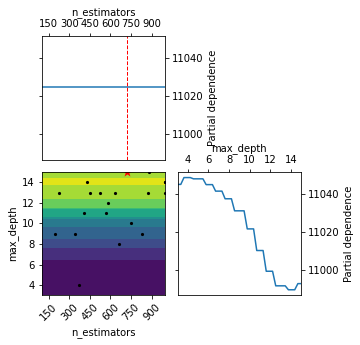

In [ ]:
dim_names = ['n_estimators', 'max_depth']
plt.rcParams["figure.figsize"] = (15,15)
plot_objective(result=gp_, plot_dims=dim_names,size=2)
plt.show()

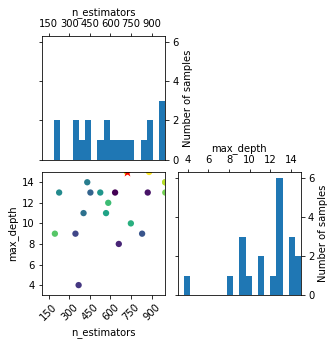

In [ ]:
plot_evaluations(result=gp_, plot_dims=dim_names)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=0, 
                           n_jobs=-1,
                           n_estimators = gp_.x[0],
                           max_depth = gp_.x[1]
                           )
rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=720, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=4)

# estimate generalization error
clf =  cross_validate(
    rf,
    X, 
    y,
    scoring='r2',
    return_train_score=True,
    
    cv=kf, # k-fold
)

clf['test_score'], clf['test_score'].mean()

(array([0.76123013, 0.6914934 , 0.67926326, 0.6756818 , 0.66067344]),
 0.6936684045990527)

#Stacking

In [ ]:
!pip install vecstack 
from vecstack import stacking

  Created wheel for vecstack: filename=vecstack-0.4.0-cp37-none-any.whl size=19877 sha256=0d6d4556de9f609fb7c68c61864bfa64ebb9468b0d9c06f45a457635ea3b32a8
  Stored in directory: /root/.cache/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


In [ ]:
models = [
    CatBoostRegressor(task_type='GPU', 
                       random_state=0, 
                       verbose=False,
                       max_bin = 254,
                       n_estimators = gbm_.x[0],
                       learning_rate = gbm_.x[1],
                       depth = gbm_.x[2],
                       l2_leaf_reg = gbm_.x[3]),
        
    RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=720, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False),
        
    XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6045963719621126, gamma=0,
             importance_type='gain', learning_rate=0.05058083584390974,
             max_delta_step=0, max_depth=10, min_child_weight=7.917729929664523,
             missing=None, n_estimators=303, n_jobs=1, nthread=None,
             objective='reg:linear', random_state=0,
             reg_alpha=18.858834096247904, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.6791237313942322, verbosity=1,
             xgb_gpu_hist=1)
]

In [ ]:
from sklearn.metrics import mean_squared_error, neg_root_mean_squared_error, r2

In [ ]:
S_train, S_test = stacking(models,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=True,            # regression task (if you need classification - set to False)
                           mode='oof_pred_bag',        # mode: oof for train set, predict test set in each fold and find mean
                           save_dir=None,              # do not save result and log (to save in current dir - set to '.')
                           metric= neg_root_mean_squared_error, # metric: callable
                           n_folds=4,                  # number of folds
                           shuffle=True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=2,)     

task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [CatBoostRegressor]
    fold  0:  [94879894.02469654]
    fold  1:  [114259421.13803849]
    fold  2:  [88429419.62781414]
    fold  3:  [110883354.74354795]
    ----
    MEAN:     [102113022.38352427] + [10770478.89650570]
    FULL:     [102113022.38352428]

model  1:     [RandomForestRegressor]
    fold  0:  [102762837.82078305]
    fold  1:  [124529209.65040855]
    fold  2:  [89288620.82068892]
    fold  3:  [114720269.89285755]
    ----
    MEAN:     [107825234.54618451] + [13188993.57161109]
    FULL:     [107825234.54618451]

model  2:     [XGBRegressor]
[05:41:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  0:  [94726948.07347646]
[05:42:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  1:  [10244

In [ ]:
# Initialize 2nd level model
model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=720, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)
    
# Fit 2nd level model
model = model.fit(S_train, y_train)

# Predict
y_pred = model.predict(S_test)

# Final prediction score
print('Final prediction score: [%.8f]' % np.sqrt(mean_squared_error(y_test, y_pred)))

Final prediction score: [10453.86100004]


In [ ]:
X.shape, y.shape, dft.shape

((19229, 95), (19229,), (8245, 95))

In [ ]:
S_train, S_test = stacking(models,                     # list of models
                           X, y, dft,                  # data
                           regression=True,            # regression task (if you need classification - set to False)
                           mode='oof_pred_bag',        # mode: oof for train set, predict test set in each fold and find mean
                           save_dir=None,              # do not save result and log (to save in current dir - set to '.')
                           metric=mean_squared_error, # metric: callable
                           n_folds=4,                  # number of folds
                           shuffle=True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=2,)   

task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [CatBoostRegressor]
    fold  0:  [113904305.42026265]
    fold  1:  [78273607.01914431]
    fold  2:  [95765860.78531845]
    fold  3:  [122840053.20083949]
    ----
    MEAN:     [102695956.60639122] + [17145619.68981308]
    FULL:     [102696539.49415523]

model  1:     [RandomForestRegressor]
    fold  0:  [113604420.63007101]
    fold  1:  [79715265.34809770]
    fold  2:  [97591282.89357610]
    fold  3:  [123132850.75054786]
    ----
    MEAN:     [103510954.90557316] + [16493742.79179847]
    FULL:     [103511479.81408243]

model  2:     [XGBRegressor]
[06:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  0:  [107420522.60664625]
[06:19:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  1:  [74987

In [ ]:
# Initialize 2nd level model
model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=720, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)
    
# Fit 2nd level model
model = model.fit(S_train, y)

# Predict
y_pred = model.predict(S_test)
print(y_pred.shape)

(8245,)


In [ ]:
result = pd.DataFrame({'Price':y_pred})
result.head()
result.to_csv('stacked_ensemble_regr_1.csv', index=False)

#AutoGluon

In [ ]:
!pip uninstall -y mkl
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0"
!pip install autogluon
!pip install -U ipykernel

In [ ]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset('/content/drive/MyDrive/Projects/TheMathCompany_.DSHH/fe_train.csv').drop(labels=['ID'],axis=1)
test_data = TabularDataset('/content/drive/MyDrive/Projects/TheMathCompany_.DSHH/fe_test.csv')

#create temp dataset to hold ID
test_data_tmp = pd.DataFrame()
test_data_tmp['ID'] = test_data['ID'].copy()
test_data = test_data.drop(labels=['ID'],axis=1)

label = 'Price'
print("Summary of Price variable: \n", train_data[label].describe())

In [ ]:
save_path = 'agModels-predict'  # specifies folder to store trained models
predictor = TabularPredictor(label=label, 
                             path=save_path,
                             eval_metric= 'r2').fit(train_data, 
                                                    presets='best_quality',
                                                    excluded_model_types = ['NN', 'FASTAI', 'KNN'],
                                                    auto_stack=True)

Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "agModels-predict/"
AutoGluon Version:  0.2.0
Train Data Rows:    19229
Train Data Columns: 95
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (308906.0, 1.0, 17114.46565, 18280.79671)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12446.8 MB
	Train Data (Original)  Memory Usage: 14.61 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:


[1000]	train_set's l2: 5.08862e+07	train_set's r2: 0.84819	valid_set's l2: 1.04435e+08	valid_set's r2: 0.678587
[1000]	train_set's l2: 5.16822e+07	train_set's r2: 0.846238	valid_set's l2: 9.13965e+07	valid_set's r2: 0.711053
[1000]	train_set's l2: 5.18448e+07	train_set's r2: 0.844957	valid_set's l2: 8.45575e+07	valid_set's r2: 0.745332
[1000]	train_set's l2: 5.12029e+07	train_set's r2: 0.847805	valid_set's l2: 8.82051e+07	valid_set's r2: 0.718853
[1000]	train_set's l2: 5.12155e+07	train_set's r2: 0.847628	valid_set's l2: 9.2602e+07	valid_set's r2: 0.707509
[2000]	train_set's l2: 3.74272e+07	train_set's r2: 0.88865	valid_set's l2: 9.11647e+07	valid_set's r2: 0.71205
[1000]	train_set's l2: 5.05175e+07	train_set's r2: 0.84737	valid_set's l2: 1.21611e+08	valid_set's r2: 0.664806
[2000]	train_set's l2: 3.74133e+07	train_set's r2: 0.886962	valid_set's l2: 1.18789e+08	valid_set's r2: 0.672583
[3000]	train_set's l2: 3.07815e+07	train_set's r2: 0.906999	valid_set's l2: 1.18158e+08	valid_set's r

	0.6912	 = Validation r2 score
	159.43s	 = Training runtime
	2.23s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...


[1000]	train_set's l2: 3.15194e+07	train_set's r2: 0.904094	valid_set's l2: 1.32833e+08	valid_set's r2: 0.653955
[1000]	train_set's l2: 3.2325e+07	train_set's r2: 0.903332	valid_set's l2: 7.42375e+07	valid_set's r2: 0.776413
[1000]	train_set's l2: 3.22522e+07	train_set's r2: 0.904134	valid_set's l2: 7.73692e+07	valid_set's r2: 0.753393
[1000]	train_set's l2: 3.22485e+07	train_set's r2: 0.904057	valid_set's l2: 8.51876e+07	valid_set's r2: 0.730928
[2000]	train_set's l2: 2.05593e+07	train_set's r2: 0.938834	valid_set's l2: 8.44631e+07	valid_set's r2: 0.733217
[1000]	train_set's l2: 3.1378e+07	train_set's r2: 0.905197	valid_set's l2: 1.08584e+08	valid_set's r2: 0.700713
[2000]	train_set's l2: 2.07587e+07	train_set's r2: 0.937281	valid_set's l2: 1.06993e+08	valid_set's r2: 0.705098
[3000]	train_set's l2: 1.5632e+07	train_set's r2: 0.952771	valid_set's l2: 1.05441e+08	valid_set's r2: 0.709373
[4000]	train_set's l2: 1.25926e+07	train_set's r2: 0.961954	valid_set's l2: 1.05523e+08	valid_set's

	0.7243	 = Validation r2 score
	137.26s	 = Training runtime
	1.79s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	0.7027	 = Validation r2 score
	57.98s	 = Training runtime
	1.81s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	0.7168	 = Validation r2 score
	214.53s	 = Training runtime
	0.08s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	0.7108	 = Validation r2 score
	34.55s	 = Training runtime
	1.82s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	0.7214	 = Validation r2 score
	355.99s	 = Training runtime
	0.95s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ...


[1000]	train_set's l2: 1.12294e+07	train_set's r2: 0.966499	valid_set's l2: 8.6596e+07	valid_set's r2: 0.733489
[1000]	train_set's l2: 1.09977e+07	train_set's r2: 0.967281	valid_set's l2: 8.26551e+07	valid_set's r2: 0.738928
[1000]	train_set's l2: 1.11274e+07	train_set's r2: 0.966381	valid_set's l2: 1.08102e+08	valid_set's r2: 0.702038
[1000]	train_set's l2: 1.13117e+07	train_set's r2: 0.966423	valid_set's l2: 7.00345e+07	valid_set's r2: 0.773886


	0.7178	 = Validation r2 score
	99.64s	 = Training runtime
	1.31s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	0.7392	 = Validation r2 score
	1.37s	 = Training runtime
	0.0s	 = Validation runtime
Excluded Model Types: ['NN', 'FASTAI', 'KNN']
	Found 'NN' model in hyperparameters, but 'NN' is present in `excluded_model_types` and will be removed.
	Found 'FASTAI' model in hyperparameters, but 'FASTAI' is present in `excluded_model_types` and will be removed.
	Found 'KNN' model in hyperparameters, but 'KNN' is present in `excluded_model_types` and will be removed.
	Found 'KNN' model in hyperparameters, but 'KNN' is present in `excluded_model_types` and will be removed.
Fitting model: LightGBMXT_BAG_L2 ...
	0.7249	 = Validation r2 score
	29.7s	 = Training runtime
	0.3s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ...
	0.7256	 = Validation r2 score
	23.47s	 = Training runtime
	0.16s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ...
	0.723	 = Validation 

In [ ]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

AutoGluon infers problem type is:  regression
AutoGluon identified the following types of features:
('float', []) : 86 | ['Levy', 'Category', 'Engine volume', 'Cylinders', 'Cylinders_cb', ...]
('int', [])   :  9 | ['Prod. year', 'Leather interior', 'Fuel type', 'Mileage', 'Gear box type', ...]


In [ ]:
results = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3   0.741196      12.240751  1166.213134                0.002116           1.358785            3       True         16
1      WeightedEnsemble_L2   0.739180       7.761212   901.318407                0.002100           1.365046            2       True          8
2          CatBoost_BAG_L2   0.735000      10.026905  1080.683011                0.035208          21.300593            2       True         12
3     ExtraTreesMSE_BAG_L2   0.734025      11.904963  1113.851896                1.913266          54.469478            2       True         13
4          LightGBM_BAG_L2   0.725621      10.151747  1082.854987                0.160049          23.472568            2       True         10
5        LightGBMXT_BAG_L2   0.724928      10.290162  1089.084278         

In [ ]:
predictor.leaderboard(train_data, silent=True,)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesMSE_BAG_L1,0.951816,0.710813,11.773576,1.821428,34.554889,11.773576,1.821428,34.554889,1,True,5
1,RandomForestMSE_BAG_L1,0.950733,0.702715,11.379278,1.806694,57.977058,11.379278,1.806694,57.977058,1,True,3
2,LightGBMLarge_BAG_L1,0.941654,0.717796,12.672306,1.308111,99.644713,12.672306,1.308111,99.644713,1,True,7
3,WeightedEnsemble_L2,0.933433,0.739180,67.636794,7.761212,901.318407,0.006021,0.002100,1.365046,2,True,8
4,RandomForestMSE_BAG_L2,0.928190,0.723045,93.683156,11.868083,1189.845041,2.024987,1.876385,130.462623,2,True,11
5,XGBoost_BAG_L2,0.924183,0.715913,99.865195,10.766404,1183.894189,8.207026,0.774707,124.511771,2,True,14
6,ExtraTreesMSE_BAG_L2,0.922771,0.734025,93.704950,11.904963,1113.851896,2.046781,1.913266,54.469478,2,True,13
7,XGBoost_BAG_L1,0.918588,0.721431,10.644222,0.953700,355.987681,10.644222,0.953700,355.987681,1,True,6
8,WeightedEnsemble_L3,0.917171,0.741196,95.861156,12.240751,1166.213134,0.011286,0.002116,1.358785,3,True,16
9,LightGBMLarge_BAG_L2,0.910860,0.720753,93.641155,10.191156,1095.758404,1.982985,0.199459,36.375986,2,True,15


In [ ]:
predictor = TabularPredictor.load(save_path) 
y_pred = predictor.predict(test_data,  model= predictor.get_model_best(), as_pandas=True)
subx = pd.DataFrame()
subx['Price'] = y_pred
subx.to_csv('out2.csv', index=False)

Predictions:  
 0       15303.309570
1       18110.746094
2        7216.854980
3        4291.127930
4        4139.128906
            ...     
8240     7292.358887
8241    18826.531250
8242     1103.352905
8243    46510.843750
8244     1708.250000
Name: Price, Length: 8245, dtype: float32


In [ ]:
predictor = TabularPredictor.load(save_path) 
y_pred = predictor.predict(test_data,  model= 'RandomForestMSE_BAG_L2', as_pandas=True)
subx = pd.DataFrame()
subx['Price'] = y_pred
subx.to_csv('out3.csv', index=False)